In [1]:
import pybaseball as pyb
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import seaborn as sns
import math
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Vertical Approach Angle (VAA)

더스틴 니퍼트 선수의 팬이었다. 니퍼트 선수에 대한 해설을 들을 때 자주 들었던 말이 있다. 
   
"*2m가 넘는 큰 키에서 비롯되는 위에서 아래로 찍어내리는 위력적인 공...*".
   
**위에서 아래로 찍어내리는 공이 정말 위력적이고 효과적일까?**
   
투수가 던진 공이 home_plate를 통과할 때의 각도를 Vertical Approach Angle(VAA)라고 한다. VAA는 완전히 평평한 움직임의 각도(0도, 밑의 그림의 점선)를 기준으로 음수로 표현되는데, 수치가 작아질수록(0에 가까워질수록) 공의 움직임이 평평하고(flat), 반대로 VAA가 커질수록(0과 멀어질수록) 각이 깊은(steep) 공이라고 표현한다. 이 VAA는 공의 속도(velocity), 투구 높이(release_height), 투구 거리(extension), 그리고 투구 위치(zone) 등의 영향을 받아 달라진다. 


flat한 공과 steep한 공의 효과 차이를 확인하기 위해서, 포심과 커브, 두 구종의 VAA에 따른 공의 헛스윙율(Whiff %)를 비교 분석해보았다.

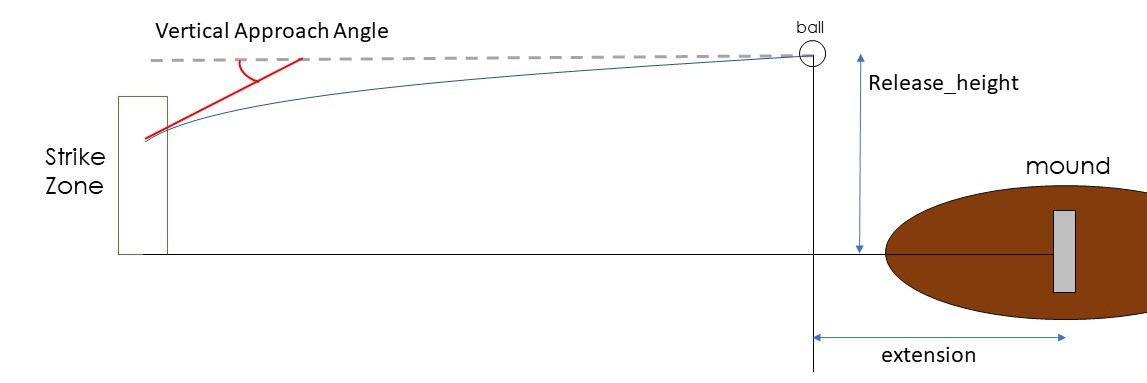

# **[0. Data ](#data)**
   - VAA Calculation
   - VAA Distribution
   - Pitch Location에 따른 VAA 구분
    

# **[1.포심 ](#fourseam)**
   - ( 구속 + Release Point )과 VAA의 상관관계
   - VAA와 ( Swing%, Whiff%)의 상관관계
   - 선수별 평균 VAA와 Whiff % 시각화

# **[2. 커브 ](#curve)**
   - ( 구속 + Release Point )과 VAA의 상관관계
   - VAA와 ( Swing%, Whiff%)의 상관관계
   - 선수별 평균 VAA와 Whiff % 시각화

----

<a id="data"></a>
# 0. Data Importing & Calculating

21시즌 Statcast의 데이터를 이용하여 VAA를 계산하였다. 계산은 팬그래프에 올라온 정보를 참조하였다.

In [2]:
mlb_21=pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [02:54<00:00,  1.06it/s]


### - VAA equation   
    vy_f = -sqrt(vy0² – (2 * ay * (y0 – yf)))   
    t = (vy_f – vy0) / ay   
    vz_f = vz0 + (az * t)   
    VAA = -arctan(vz_f/vy_f) * (180 / pi)   

    
    

- vy0 = The velocity of the pitch, in feet per second, in y-dimension*, determined at y=50 feet. (*toward home plate)   
- ay = The acceleration of the pitch, in feet per second per second, in y-dimension, determined at y=50 feet.   
- y0 = 50 (“y=50 feet”).   
- yf = 17/12 (home plate, converted to inches).   
- vz0 = The velocity of the pitch, in feet per second, in z-dimension, determined at y=50 feet. (vertically)   
- az = The acceleration of the pitch, in feet per second per second, in z-dimension, determined at y=50 feet.   

참조: https://blogs.fangraphs.com/a-visualized-primer-on-vertical-approach-angle-vaa/

In [3]:
y0 = 50
yf = 17/12
mlb_21['vy_f'] = -np.sqrt(mlb_21['vy0']**2 - (2*mlb_21['ay']*(y0-yf)))
mlb_21['t'] = (mlb_21['vy_f'] - mlb_21['vy0'])/mlb_21['ay']
mlb_21['vz_f'] = mlb_21['vz0'] + (mlb_21['az'] * mlb_21['t'])
mlb_21['VAA'] = np.rad2deg(-np.arctan(mlb_21['vz_f']/mlb_21['vy_f']))

In [4]:
# 연속적 값을 가지는 VAA를 그룹화하기 위해서, 반올림하였다.
# 반올림하여 비슷한 VAA값을 가지는 투구들을 그룹화하여 각 그룹의 Whiff %를 계산하였다.
mlb_21['round_vaa'] = round(mlb_21['VAA'],1)
mlb_21['round_plate_z'] = round(mlb_21['plate_z'],1)

swing = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']
miss = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']
mlb_21['swing'] = np.where(mlb_21['description'].isin(swing),1,0)
mlb_21['miss'] = np.where(mlb_21['description'].isin(miss),1,0)

### - VAA distribution

포심과 커브, 두 구종에 대해 VAA 분포를 확인해보았다. 예상대로 포심의 VAA는 평균 -5를 기준으로 상대적으로 작은 값에 분포하고 있었고, 커브의 VAA는 평균 -10을 기준으로 상대적으로 큰 값에 넓게 분포하고 있었다.

In [114]:
# 포심과 커브 구분
ff = mlb_21[mlb_21['pitch_name']=='4-Seam Fastball']
cb = mlb_21[mlb_21['pitch_name']=='Curveball']
ff_cb = pd.concat([ff, cb])

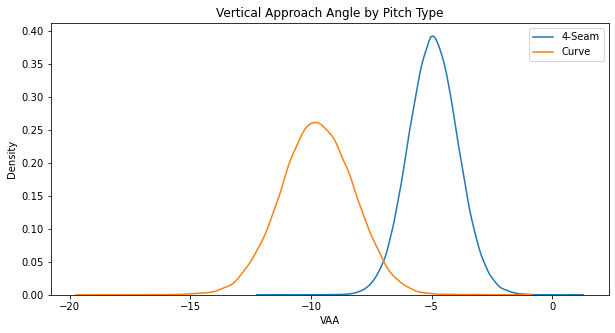

In [90]:
plt.figure(figsize=(10,5))
sns.distplot(ff['VAA'], hist=False, label='4-Seam')
sns.distplot(cb['VAA'], hist=False, label='Curve')
plt.title("Vertical Approach Angle by Pitch Type")
plt.legend()
plt.show()

### - Pitch Location에 따른 VAA 구분

VAA는 투수가 던진 공의 Pitch Location에 큰 영향을 받는다. 당연하게도, 존의 위쪽에 던진 공일수록 VAA 각이 작아지고 존의 아래쪽으로 던진 공일수록 VAA 각이 커진다. VAA 차이에 따른 투구 결과 비교를 위해서, 공의 높낮이 차이에 따른 영향을 최대한 줄여서 같은 높이에 투구된 공들의 데이터들을 비교 분석하였다.
    
Statcast 데이터에는 'zone'이라는 데이터가 존재하는데, 아래 그림에서 어느 Zone에 투구되었는지 알려주는 데이터이다. 같은 높이에 던져진 공의 VAA에 따른 결과 차이를 분석하기 위해, 존의 두가지 구역을 나누어 활용하였다. Top_Zone(1,2,3)과 Bottom_Zone(7,8,9)로 나누어서 높게 던져진 공과 낮게 던져진 공을 분류하여 각각 VAA에 따른 차이를 분석하였다.
   
밑의 모든 분석은 top_zone과 bot_zone으로 구분지어 분석을 수행하였다.

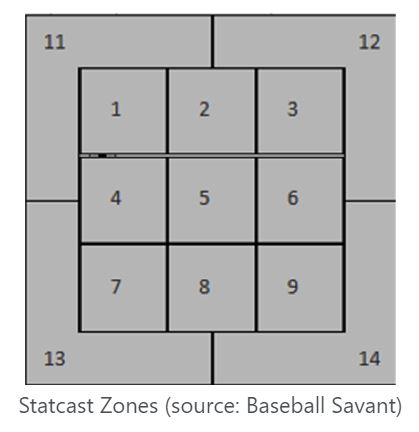

In [6]:
# 높게 던져진 공과 낮게 던져진 공 분류
up = [1,2,3]
down = [7,8,9]

mlb_21['up_down'] = np.where(mlb_21['zone'].isin(up), 'up', '')
mlb_21['up_down'] = np.where(mlb_21['zone'].isin(down), 'down', mlb_21['up_down'])

In [106]:
# up과 down으로 구분된 두가지 투구에 대해 
# 구종별 VAA 값으로 그룹화하여 Whiff %를 계산
pitch_up_whiff = ff_cb[ff_cb['up_down']=='up'].groupby(['pitch_name', 'round_vaa']).agg({
    'release_pos_z': 'mean',
    'release_speed': 'mean',
    'release_extension': 'mean',
    'swing':'sum',
    'miss':'sum',
    'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count', 'round_vaa': 'VAA'})
pitch_up_whiff['swing %'] = pitch_up_whiff['swing']/pitch_up_whiff['count']
pitch_up_whiff['whiff %'] = pitch_up_whiff['miss']/pitch_up_whiff['swing']
pitch_up_whiff = pitch_up_whiff[pitch_up_whiff['swing']>50]

pitch_down_whiff = ff_cb[ff_cb['up_down']=='down'].groupby(['pitch_name', 'round_vaa']).agg({
    'release_pos_z': 'mean',
    'release_speed': 'mean',
    'release_extension': 'mean',
    'swing':'sum',
    'miss':'sum',
    'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count', 'round_vaa': 'VAA'})
pitch_down_whiff['swing %'] = pitch_down_whiff['swing']/pitch_down_whiff['count']
pitch_down_whiff['whiff %'] = pitch_down_whiff['miss']/pitch_down_whiff['swing']
pitch_down_whiff = pitch_down_whiff[pitch_down_whiff['swing']>50]

----

<a id="fourseam"></a>
# 1. 포심 (4-Seam Fastball)

In [116]:
ff_top = pitch_up_whiff[pitch_up_whiff['pitch_name']=='4-Seam Fastball']
ff_bot = pitch_down_whiff[pitch_down_whiff['pitch_name']=='4-Seam Fastball']

### 1-1. ( VAA )  vs ( release_point )

투수가 공을 던지는 순간의 릴리즈 포인트와 구속이 VAA에 어떠한 영향을 미치는지 확인해보았다. 세 그래프의 x축은 각각 구속과 투수의 릴리즈 포인트 높이와 extension을 나타낸다. 세 그래프의 y축은 VAA(음수)로 표현되어있다. 즉, y축값이 커질수록 0에 가까워지기 때문에 flat한 공이라는 의미가 되고, 반대로 y축값이 작아지면 각도가 커져 steep한 공이라는 의미가 된다.

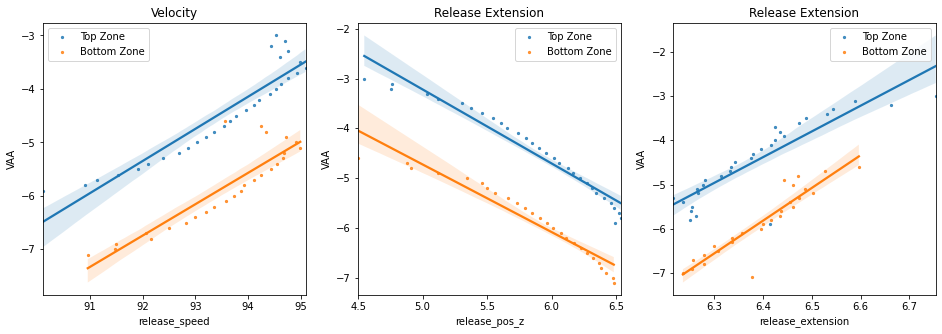

In [117]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.regplot(data=ff_top, x='release_speed', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=ff_bot, x='release_speed', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Velocity')
plt.legend()

plt.subplot(1,3,2)
sns.regplot(data=ff_top, x='release_pos_z', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=ff_bot, x='release_pos_z', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Release Extension')
plt.legend()

plt.subplot(1,3,3)
sns.regplot(data=ff_top, x='release_extension', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=ff_bot, x='release_extension', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Release Extension')
plt.legend()
plt.show()

왼쪽 그래프를 확인해보면, **구속이 클수록 VAA 각도가 작아지는 것**(0에 가까워지는 것)을 확인할 수 있다. 공이 빠르면 그만큼 공이 중력에 의해 떨어지는 것에 영향을 받지 않고 home_plate를 통과하기 때문에 VAA가 작아진다.

   
가운데 그래프를 확인해보면, **릴리즈 포인트의 높이(Release Height, release_pos_z)가 커질수록 VAA 각도가 커지는 것**을 확인할 수 있다. 릴리즈 포인트 높이가 높으면, 더 높은 곳에서 존을 향해 아래로 내리꽂듯이 던지기 때문에 VAA가 커진다.
    
오른쪽 그래프를 보면 투수가 공을 던지는 순간의 y축 거리인 extension 또한 VAA에 영향을 미쳤다. **extension을 더 길게 가져가는 투수일수록 VAA 각도가 작아지는 것**을 확인할 수 있었다. extension이 커질수록 공의 이동거리가 짧아지게 되고, 이는 곧 구속이 빨라지는 것과 같은 영향을 미치기 때문에 VAA가 작아진다.  
    
이것들을 통해 포심의 구속과 릴리즈 포인트(높이와 extension)가 VAA에 영향을 미치는 것을 확인할 수 있었다.   
   
그렇다면 VAA는 투구 결과에는 어떠한 영향을 미칠까?

### 1-2. ( VAA )  vs ( Swing %, Whiff % )

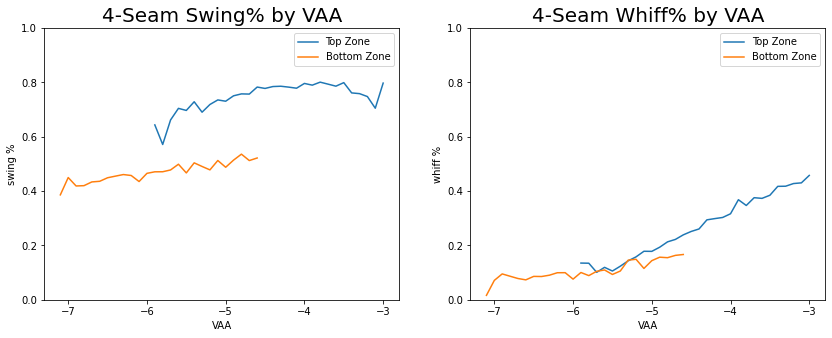

In [118]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.lineplot(data=ff_top, x='VAA', y='swing %', label='Top Zone')
sns.lineplot(data=ff_bot, x='VAA', y='swing %', label='Bottom Zone')
plt.title('4-Seam Swing% by VAA', size=20)
plt.ylim(0,1)
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(data=ff_top, x='VAA', y='whiff %', label='Top Zone')
sns.lineplot(data=ff_bot, x='VAA', y='whiff %', label='Bottom Zone')
plt.title('4-Seam Whiff% by VAA', size=20)
plt.ylim(0,1)
plt.legend()
plt.show()

- Swing %:   
포심의 경우, 왼쪽 그래프를 확인해보면 Swing %가 VAA 각도에 관계없이 대체적으로 일정한 모습을 보여주었다. 존의 위쪽에 분포한 포심이 아래쪽에 분포한 포심보다 Swing %가 더 높았다. 타자들이 **낮은 공보다 하이 패스트볼에 대해 더 반응하여 스윙을 한다**는 것을 알 수 있다.   
   
   
- Whiff %:   
오른쪽 그래프는 Whiff %를 표현하였다. 낮게 깔리는 포심은 Whiff %가 일정하게 낮은 반면에, 하이 패스트볼은 VAA 각도가 작아질수록 Whiff %가 크게 증가하는 것을 확인할 수 있었다. 이는 포심을 steep하게 던지는 것보다 **flat하게 던지는 것이 타자들의 헛스윙을 유도하는 것에 효과적**이라는 것을 보여준다.

### 1-3. Whiff % by Player

In [68]:
vaa_player_ff_up = ff[ff['up_down']=='up'].groupby(['player_name']).agg({'VAA': 'mean', 'swing':'sum', 'miss':'sum', 'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count'})
vaa_player_ff_up['whiff'] = vaa_player_ff_up['miss']/vaa_player_ff_up['swing']
vaa_player_ff_down = ff[ff['up_down']=='down'].groupby(['player_name']).agg({'VAA': 'mean', 'swing':'sum', 'miss':'sum', 'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count'})
vaa_player_ff_down['whiff'] = vaa_player_ff_down['miss']/vaa_player_ff_down['swing']
vaa_player_ff_up = vaa_player_ff_up[vaa_player_ff_up['swing']>50]
vaa_player_ff_down = vaa_player_ff_down[vaa_player_ff_down['swing']>50]

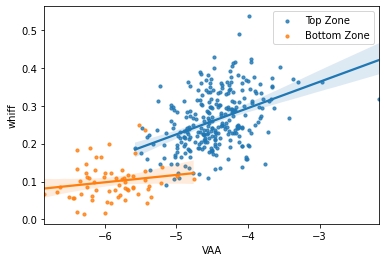

In [119]:
sns.regplot(data=vaa_player_ff_up, x='VAA', y='whiff', scatter_kws={'s':10}, label='Top Zone')
sns.regplot(data=vaa_player_ff_down, x='VAA', y='whiff', scatter_kws={'s':10}, label='Bottom Zone')
plt.legend()
plt.show()

각 선수별 포심의 평균 VAA 각도를 계산하여 Whiff%와의 관계성을 확인해보았다. 포심의 경우, 존 위쪽에 던지는 것이 대체적으로 높은 Whiff %를 얻을 수 있었다. 또한, 존의 위쪽에 던지더라도 VAA 각도가 더 낮은 투수일수록 더 높은 Whiff %를 가지는 경향이 있었다.    
    
**포심은 flat하게 던지는 하이 패스트볼이 타자들로부터 헛스윙을 더 잘 유도**해낼 수 있다는 것을 확인할 수 있었다.

----

<a id="curve"></a>
# 2. 커브 (Curveball)

In [112]:
cb_up = pitch_up_whiff[pitch_up_whiff['pitch_name']=='Curveball']
cb_down = pitch_down_whiff[pitch_down_whiff['pitch_name']=='Curveball']

### 2-1. ( VAA )  vs ( release_point )

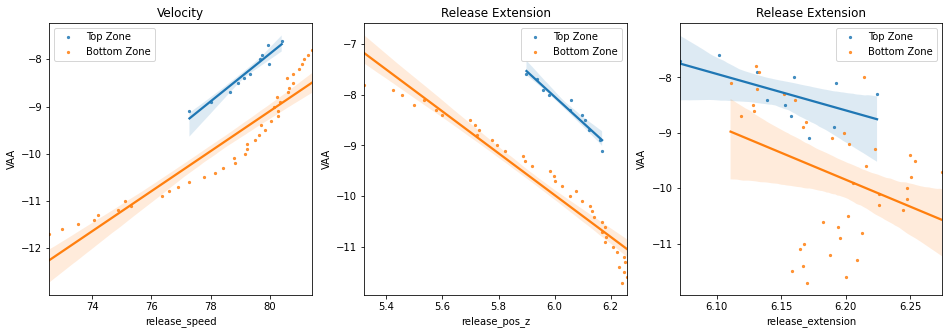

In [120]:
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
sns.regplot(data=cb_up, x='release_speed', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=cb_down, x='release_speed', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Velocity')
plt.legend()

plt.subplot(1,3,2)
sns.regplot(data=cb_up, x='release_pos_z', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=cb_down, x='release_pos_z', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Release Extension')
plt.legend()

plt.subplot(1,3,3)
sns.regplot(data=cb_up, x='release_extension', y='VAA', scatter_kws={'s':5}, label='Top Zone')
sns.regplot(data=cb_down, x='release_extension', y='VAA', scatter_kws={'s':5}, label='Bottom Zone')
plt.title('Release Extension')
plt.legend()
plt.show()

왼쪽과 가운데 그래프를 확인해보면, 포심과 마찬가지로 **커브의 구속이 클수록 VAA 각도가 작아지고, 릴리즈 포인트의 높이(Release Height, release_pos_z)가 커질수록 VAA 각도가 커지는 것**을 확인할 수 있다. 
    
포심과의 차이점이 있다면, 오른쪽 그래프에서 확인할 수 있는 extension이다. 포심과는 다르게 **커브의 VAA는 extension과 큰 상관관계가 없었다.** 포심과는 다르게 투구별 extension의 차이가 크지도 않고, extension의 크기와 상관없이 VAA 각이 커지거나 작아지는 것을 확인할 수 있었다.

### 2-2. ( VAA )  vs ( Swing %, Whiff % )

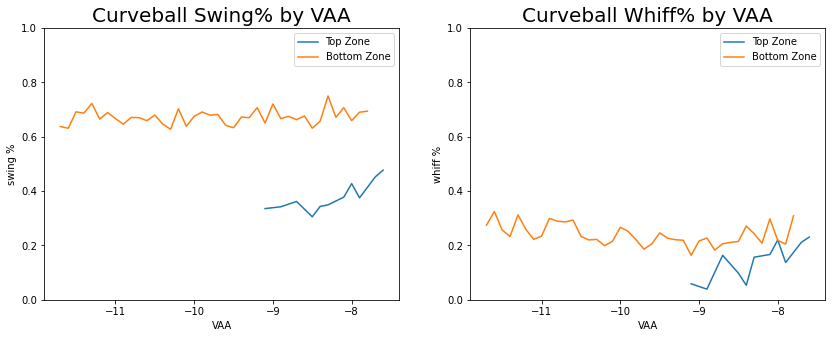

In [121]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.lineplot(data=cb_up, x='VAA', y='swing %', label='Top Zone')
sns.lineplot(data=cb_down, x='VAA', y='swing %', label='Bottom Zone')
plt.title('Curveball Swing% by VAA', size=20)
plt.ylim(0,1)
plt.legend()

plt.subplot(1,2,2)
sns.lineplot(data=cb_up, x='VAA', y='whiff %', label='Top Zone')
sns.lineplot(data=cb_down, x='VAA', y='whiff %', label='Bottom Zone')
plt.title('Curveball Whiff% by VAA', size=20)
plt.ylim(0,1)
plt.legend()
plt.show()

- Swing %:   
커브의 경우에도, 왼쪽 그래프를 확인해보면 Swing %가 VAA에 관계없이 대체적으로 일정한 모습을 보여주었다. 그러나 포심과는 반대로, 존 아래쪽에 깔리는 커브가 존 위쪽으로 들어가는 커브보다 스윙을 더 많이 이끌어냈다. 
   
   
- Whiff %:   
오른쪽 그래프는 커브의 VAA별 Whiff %를 표현하였다. 포심과는 다르게, Top Zone과 Bottom Zone 모두 VAA와 Whiff %의 큰 관계성은 없었고, 모두 낮은 Whiff %를 일정하게 유지하는 모습을 보였다.

### 2-3. Whiff % by Player

In [66]:
vaa_player_cb_up = cb[cb['up_down']=='up'].groupby(['player_name']).agg({'VAA': 'mean', 'swing':'sum', 'miss':'sum', 'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count'})
vaa_player_cb_up['whiff'] = vaa_player_cb_up['miss']/vaa_player_cb_up['swing']
vaa_player_cb_down = cb[cb['up_down']=='down'].groupby(['player_name']).agg({'VAA': 'mean', 'swing':'sum', 'miss':'sum', 'pitch_type': 'count'}).reset_index().rename(columns={'pitch_type': 'count'})
vaa_player_cb_down['whiff'] = vaa_player_cb_down['miss']/vaa_player_cb_down['swing']
vaa_player_cb_up = vaa_player_cb_up[vaa_player_cb_up['swing']>50]
vaa_player_cb_down = vaa_player_cb_down[vaa_player_cb_down['swing']>50]

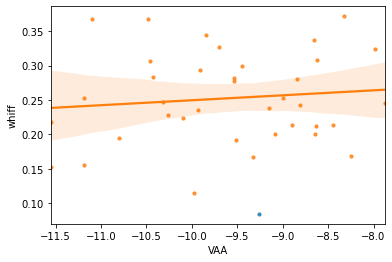

In [122]:
sns.regplot(data=vaa_player_cb_up, x='VAA', y='whiff', scatter_kws={'s':10})
sns.regplot(data=vaa_player_cb_down, x='VAA', y='whiff', scatter_kws={'s':10})
plt.show()

포심과는 다르게 커브는 VAA와 Whiff %와의 큰 상관관계를 찾을 수 없었다. 스트라이크 존 위쪽을 통과하는 커브는 거의 없었다. 존의 아래쪽을 통과하는 커브는 VAA 수치와 관계없이 높은 Swing %와 낮은 Whiff %를 나타내었다. 이것은 스트라이크 존에 들어오는 커브는 타자가 대부분 hit해낸다는 것으로 해석된다.